In [1]:
#Import packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
#DMI requires a personal key to access their API
api_key = '12a4bffe-21d5-4154-96e5-12bf959cc1dd'

In [3]:
#Defining URL for the API
url = 'https://dmigw.govcloud.dk/metObs/v1/observation'

In [4]:
#Defining data period: 2015-now
end_time = pd.datetime.today()
start_time = pd.datetime(2015,1,1)

#Creates function that convertes datetime objects to Unix microsecond string
def date_time(dt):
    '''
    Function convertes datetime objects to Unix microsecond string
    '''
    return str(int(pd.to_datetime(dt).value*10**-3))

#Specifying query parameters: 
#Personal API-key to access data, data period by using our date_time function, stationId (06184 is the DMI station at Østerbro, Kbh), 
#parameterId (temp_dry is "Present air temperature measured 2 m over terrain every 10 min") and finally the limit
#which should be around 6*24*(3650+240)=560160 observations - thus the limit should be more than this (incl. 27 of august)
params = {'api-key' : api_key,
          'from' : date_time(start_time),
          'to' : date_time(end_time),
          'stationId' : '06184',
          'parameterId' : 'temp_dry',
          'limit' : '1000000',
          }
#Requests and gets URL for the chosen query parameters.
r = requests.get(url, params=params)
print(r, r.url)

<Response [200]> https://dmigw.govcloud.dk/metObs/v1/observation?api-key=12a4bffe-21d5-4154-96e5-12bf959cc1dd&from=1420070400000000&to=1598570058700171&stationId=06184&parameterId=temp_dry&limit=1000000


In [5]:
#Defining data period: 2010-2014
end_time = pd.datetime(2014,12,31)
start_time = pd.datetime(2010,1,1)

def date_time(dt):
    '''
    Function convertes datetime objects to Unix microsecond string
    '''
    return str(int(pd.to_datetime(dt).value*10**-3))

params = {'api-key' : api_key,
          'from' : date_time(start_time),
          'to' : date_time(end_time),
          'stationId' : '06184',
          'parameterId' : 'temp_dry',
          'limit' : '10000000',
          }

r2 = requests.get(url, params=params)

In [6]:
#Extracting JSON: 2015-now
json = r.json()

#Convertes JSON to Pandas DataFrame
df = pd.DataFrame(json)

#Creates time varaible with format YYYY-MM-DD HH:MM:SS
df['time'] = pd.to_datetime(df['timeObserved'], unit='us')

#Drop irrelevant variables
df = df.drop(['_id', 'timeCreated', 'timeObserved'], axis=1)

#Index the time variables
df.index = df['time']

In [7]:
#Extracting JSON: 2010-2014
json2 = r2.json()

#Convertes JSON to Pandas DataFrame
df2 = pd.DataFrame(json2)

#Creates time varaible with format YYYY-MM-DD HH:MM:SS
df2['time'] = pd.to_datetime(df2['timeObserved'], unit='us')

#Drop irrelevant variables
df2 = df2.drop(['_id', 'timeCreated', 'timeObserved'], axis=1)

#Index the time variables
df2.index = df2['time']

In [21]:
#Creates month-year variable with format YYYY-MM
df['mdr']=df.time.astype(str).str[:7]
df2['mdr']=df2.time.astype(str).str[:7]

In [25]:
#Calculates monthly average
mean=df.groupby(['mdr'])['value'].mean().copy()
mean2=df2.groupby(['mdr'])['value'].mean().copy()

In [29]:
#Merge data to df_weather
df_weather = pd.DataFrame(data = mean , index = mean.index)
df_weather2 = pd.DataFrame(data = mean2 , index = mean2.index)
df_weather_samlet = pd.concat([df_weather2 , df_weather])
df_weather_samlet['date']=df_weather_samlet.index

,value,date
mdr,,
2010-01,-2.511508,2010-01
2010-02,-1.219032,2010-02
2010-03,3.262522,2010-03
2010-04,7.838814,2010-04
2010-05,10.449047,2010-05
...,...,...
2020-04,8.400741,2020-04
2020-05,11.147368,2020-05
2020-06,17.608223,2020-06


In [33]:
#Missing values - there are 123 so 5 missing values (12*10+8=128)
#We use the average temperature from the year before
missing=pd.DataFrame({'date':['2014-12','2015-01','2015-02','2015-03','2015-04'],'value':df_weather_samlet.value[47:52]})
df_weather_final=df_weather_samlet.append(missing)

,value,date
mdr,,
2010-01,-2.511508,2010-01
2010-02,-1.219032,2010-02
2010-03,3.262522,2010-03
2010-04,7.838814,2010-04
2010-05,10.449047,2010-05
...,...,...
2013-12,5.314945,2014-12
2014-01,1.644932,2015-01
2014-02,4.217320,2015-02


In [34]:
#Export
df_weather_final.to_csv(r'df_weather_final.csv')

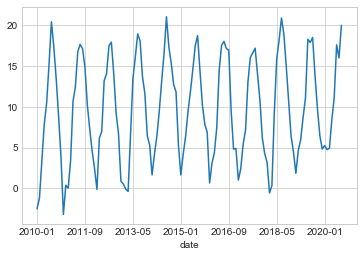

In [35]:
#A view of the data - looks normal with winter and summer season
avg_temp = df_weather_final.groupby('date')['value'].agg('mean')
avg_temp.plot()
plt.show()